In [288]:
import torch
import torchvision
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor, Normalize, Compose, Resize
import matplotlib.pyplot as plt
%matplotlib inline
from torch.utils.data import DataLoader
import torch.nn as nn
from torch.nn import Sequential
import os

In [289]:
if torch.cuda.is_available:
  Device = 'cuda'
else:
  Device = 'cpu'
Device = 'cpu'

In [290]:
transformer = Compose([
    ToTensor(),
    Resize(28),
    Normalize((0.5,),(0.5,),inplace=True)
])

In [291]:
dataset = MNIST(root='.',train=True,download=False,transform=transformer)

In [292]:
def denorm(x):
  out = (x+1)/2
  return out.clamp(0,1)

In [293]:
img,label = dataset[0]

In [294]:
d_img=denorm(img)

In [295]:
denorm_img = d_img.permute(1,2,0)

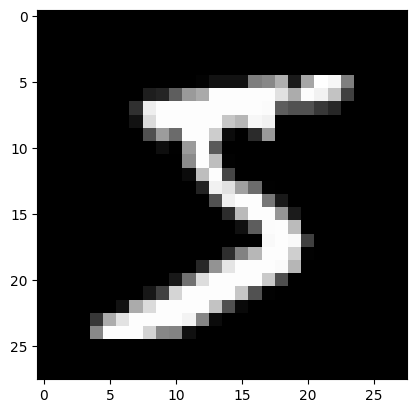

In [296]:
plt.imshow(denorm_img,cmap='gray')

In [297]:
batch_size = 150
data_loader = DataLoader(dataset,batch_size, shuffle = True)

In [298]:
image_size = 28*28
hidden_size = 256

In [299]:
D = Sequential(
    nn.Linear(image_size,hidden_size),
    nn.LeakyReLU(0.2),
    nn.Linear(hidden_size,hidden_size),
    nn.LeakyReLU(0.2),
    nn.Linear(hidden_size,1),
    nn.Sigmoid()
)

In [300]:
latent_size = 64

In [301]:
G = Sequential(
    nn.Linear(latent_size,hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size,hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size,image_size),
    nn.Tanh()
)

In [302]:
D.to(Device)
G.to(Device)

Sequential(
  (0): Linear(in_features=64, out_features=256, bias=True)
  (1): ReLU()
  (2): Linear(in_features=256, out_features=256, bias=True)
  (3): ReLU()
  (4): Linear(in_features=256, out_features=784, bias=True)
  (5): Tanh()
)

## ---------------------------
### Tanh() -> (-1,1)
### ReLU -> (0,x)
### LeakyReLU ->
### Sigmoid -> (0,1)
### Softmax -> (0,1) Multiclass

In [303]:
rand_size = torch.randn(2,latent_size)
rand_size.shape

torch.Size([2, 64])

In [304]:
y = G(rand_size)

In [305]:
gen_imgs = denorm(y)

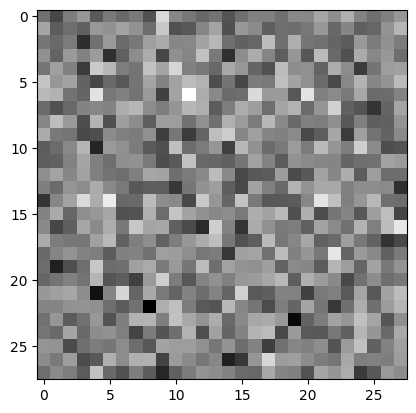

In [306]:
plt.imshow(gen_imgs.reshape(-1,28,28).detach()[0], cmap='gray');

In [307]:
criterion = nn.BCELoss()
d_optimizer = torch.optim.Adam(D.parameters(), lr=0.0002)

In [308]:
def reset_grad():
    d_optimizer.zero_grad()
    g_optimizer.zero_grad()

def train_discriminator(images):
    fake_labels = torch.zeros(batch_size,1).to(Device)
    real_labels = torch.ones(batch_size,1).to(Device)

    # images = images.view(-1, 784).to(Device)     # Fixed an error

    # Discriminator Loss for real image
    outputs = D(images)
    d_loss_real = criterion(outputs,real_labels)
    real_scores = outputs

    # Discriminator Loss for fake image
    input_for_fake = torch.randn(batch_size,latent_size).to(Device)
    fake_img = G(input_for_fake)
    outputs = D(fake_img)
    d_loss_fake = criterion(outputs,fake_labels)
    fake_scores = outputs

    # Total Discriminator loss
    d_loss = d_loss_real + d_loss_fake
    reset_grad()
    d_loss.backward()
    d_optimizer.step()

    return d_loss, real_scores, fake_scores

In [309]:
g_optimizer = torch.optim.Adam(G.parameters(),lr = 0.0002)

In [310]:
def train_generator():
  input_for_fake = torch.randn(batch_size,latent_size).to(Device)
  fake_images = G(input_for_fake)
  fool_labels = torch.ones(batch_size,1).to(Device)
  outputs = D(fake_images)
  g_loss = criterion(outputs,fool_labels)

  reset_grad()
  g_loss.backward()
  g_optimizer.step()
  return g_loss, fake_images

In [311]:
dir ='training_samples'
if not os.path.exists(dir):
  os.mkdir(dir)

## Copy-pasted

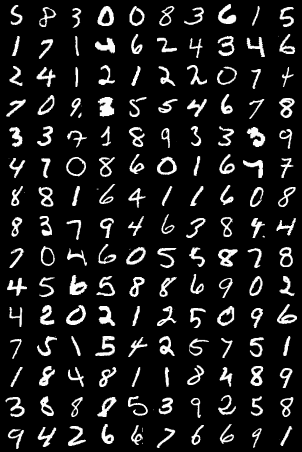

In [312]:
from IPython.display import Image
from torchvision.utils import save_image

# Save some real images
for images, _ in data_loader:
    images = images.reshape(images.size(0), 1, 28, 28)
    save_image(denorm(images), os.path.join(dir, 'real_images.png'), nrow=10)
    break

Image(os.path.join(dir, 'real_images.png'))

Saving fake_images-0000.png


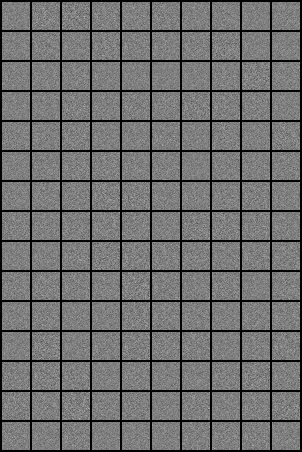

In [313]:
sample_vectors = torch.randn(batch_size, latent_size).to(Device)

def save_fake_images(index):
    fake_images = G(sample_vectors)
    fake_images = fake_images.reshape(fake_images.size(0), 1, 28, 28)
    fake_fname = 'fake_images-{0:0=4d}.png'.format(index)
    print('Saving', fake_fname)
    save_image(denorm(fake_images), os.path.join(dir, fake_fname), nrow=10)

# Before training
save_fake_images(0)
Image(os.path.join(dir, 'fake_images-0000.png'))

In [ ]:
%%time

num_epochs = 300
total_step = len(data_loader)
d_losses, g_losses, real_scores, fake_scores = [], [], [], []

for epoch in range(num_epochs):
    for i, (images, _) in enumerate(data_loader):
        # Load a batch & transform to vectors
        images = images.reshape(batch_size, -1).to(Device)

        # Train the discriminator and generator
        d_loss, real_score, fake_score = train_discriminator(images)
        g_loss, fake_images = train_generator()

        # Inspect the losses
        if (i+1) % 200 == 0:
            d_losses.append(d_loss.item())
            g_losses.append(g_loss.item())
            real_scores.append(real_score.mean().item())
            fake_scores.append(fake_score.mean().item())
            print('Epoch [{}/{}], Step [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}, D(x): {:.2f}, D(G(z)): {:.2f}'
                  .format(epoch, num_epochs, i+1, total_step, d_loss.item(), g_loss.item(),
                          real_score.mean().item(), fake_score.mean().item()))

    # Sample and save images
    save_fake_images(epoch+1)

Epoch [0/300], Step [200/400], d_loss: 0.0539, g_loss: 4.6213, D(x): 0.98, D(G(z)): 0.04
Epoch [0/300], Step [400/400], d_loss: 0.1228, g_loss: 4.8477, D(x): 0.97, D(G(z)): 0.08
Saving fake_images-0001.png
Epoch [1/300], Step [200/400], d_loss: 0.0427, g_loss: 5.2168, D(x): 0.99, D(G(z)): 0.03
Epoch [1/300], Step [400/400], d_loss: 0.0691, g_loss: 5.1727, D(x): 0.97, D(G(z)): 0.04
Saving fake_images-0002.png
Epoch [2/300], Step [200/400], d_loss: 0.0648, g_loss: 4.5593, D(x): 0.98, D(G(z)): 0.04
Epoch [2/300], Step [400/400], d_loss: 1.0622, g_loss: 2.7175, D(x): 0.75, D(G(z)): 0.44
Saving fake_images-0003.png
Epoch [3/300], Step [200/400], d_loss: 0.2480, g_loss: 3.4152, D(x): 0.95, D(G(z)): 0.15
Epoch [3/300], Step [400/400], d_loss: 0.0800, g_loss: 4.0877, D(x): 0.98, D(G(z)): 0.05
Saving fake_images-0004.png
Epoch [4/300], Step [200/400], d_loss: 0.4530, g_loss: 3.3323, D(x): 0.88, D(G(z)): 0.20
Epoch [4/300], Step [400/400], d_loss: 0.2185, g_loss: 4.7370, D(x): 0.90, D(G(z)): 0.0

## Save

In [ ]:
torch.save(D.state_dict(),'D_state_dict')
torch.save(G.state_dict(),'G_state_dict')

In [ ]:
torch.save(d_optimizer.state_dict(),'d_optimizer_state_dict')
torch.save(g_optimizer.state_dict(),'d_optimizer_state_dict')